In [1]:
import numpy as np
import pandas as pd
import os,sys,re
import matplotlib.pyplot as plt
import seaborn as sns
sys.path.append("/home/bruce1996/repo/LIHC_anomaly_detection/")
from ensemble_model_performance import *

In [2]:
def read_vote_result(result_path,prefix,np_ratio,idx) :
    vote = np.load(result_path + '%s/%s__vote_np_ratio_%d.npy' % (prefix,prefix,np_ratio))
    df = pd.Series(vote,index=idx)
    idx = df.index.str.contains("ENSG")
    return df[idx]

def read_ensemble_result(result_path,prefix,np_ratio,gene_idx) : 
    """
    Args:
        result_path (str): path of ensemble learning model result
        prefix (str): prefix of ensemble learning model
        np_ratio (int): N/P ratio of ensemble learning model
        gene_idx (list): Gene index of ensemble learning model input

    Returns:
        df[idx]: return metric of model 
        vote[idx] : return vote number without synthetic data
    """    

    vote = np.load(result_path + '%s/%s__vote_np_ratio_%d.npy' % (prefix,prefix,np_ratio))
    precision = np.load(result_path + '%s/%s__precision_np_ratio_%d.npy' % (prefix,prefix,np_ratio),allow_pickle=True)
    overall_p = np.load(result_path + '%s/%s__precision_overall_np_ratio_%d.npy' % (prefix,prefix,np_ratio),allow_pickle=True)
    recall = np.load(result_path + '%s/%s__recall_np_ratio_%d.npy' % (prefix,prefix,np_ratio),allow_pickle=True)
    overall_r = np.load(result_path + '%s/%s__recall_overall_np_ratio_%d.npy' % (prefix,prefix,np_ratio),allow_pickle=True)
    df = pd.DataFrame({'Precision' : precision,'Precision_overall' : overall_p,
                       'Recall' : recall, 'Recall_overall' : overall_r})
    vote = pd.Series(vote,index=gene_idx)
    idx = vote.index.str.contains("ENSG")
    return df,vote[idx]

### aggregate ensemble model result

In [5]:
train_path = "/home/bruce1996/data/LIHC_anomaly_detection/ensemble_training/"
result_path = "/home/bruce1996/data/LIHC_anomaly_detection/ensemble_result/with_synthetic/"
output_path = "/home/bruce1996/data/LIHC_anomaly_detection/manuscript/material/ensemble_learning_result/with_synthetic/"
prefix_list = ['hbv_only']
for prefix in prefix_list :
    exp_m = pd.read_csv(train_path + '%s_coding_gene_std_by_gene_with_synthetic.txt' % prefix,sep='\t',index_col=0)
    gene_index = list(exp_m.index)
    for np_ratio in range(5,55,5) :
        metric,vote = read_ensemble_result(result_path,prefix+'_std_by_gene',np_ratio,gene_index)
        metric.to_csv(output_path + "%s_ensemble_model_performance_np_ratio_%d.txt" % (prefix,np_ratio),sep='\t')
        vote.to_csv(output_path + "%s_ensemble_model_vote_np_ratio_%d.txt" % (prefix,np_ratio),sep='\t',header=['Vote'])

### Fig 1. Evaluate ensemble learning model performance in different N/P ratio

In [34]:
import datetime
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from joblib import parallel_backend
parallel_backend(backend='threading', n_jobs=12)

def model_performance(result_path,prefix,hallmark,gene_idx,metric,output_path) :

    no_syn_idx = gene_idx.str.contains("ENSG")
    metric_median = np.zeros(10)
    metric_std = np.zeros(10)
    overall_metric_median = np.zeros(10)
    overall_metric_std = np.zeros(10)
    auc_array = np.zeros(10) 
    auc_std_array = np.zeros(10)
    for np_idx,np_r in enumerate(np.arange(5,55,5)) :
        start = datetime.datetime.now().strftime("%H:%M:%S")
        print("%s Predict hallmark gene by vote number of np ratio %d in %s condition" % (start,np_r,prefix))  
        metric_df,vote_df = read_ensemble_result(result_path,"%s_std_by_gene" % prefix,np_r,gene_idx)
        metric_median[np_idx] = np.median(metric_df[metric].values)
        metric_std[np_idx] = np.std(metric_df[metric].values)
        overall_metric_median[np_idx] = np.median(metric_df[metric+'_overall'].values)
        overall_metric_std[np_idx] = np.std(metric_df[metric+'_overall'].values)
        no_syn_gene = gene_idx[no_syn_idx]
        x = np.array(vote_df[no_syn_gene].values)
        y = np.array([1 if x in hallmark else 0 for x in no_syn_gene])
        
        #x_train,x_test,y_train,y_test = train_test_split(x.reshape(-1, 1),y.reshape(-1, 1),test_size = 0.2,stratify = y)
        svm = SVC(kernel='linear')
        cv_score = cross_val_score(svm,x.reshape(-1,1),y,cv=5,scoring='roc_auc')
        auc_array[np_idx] = np.median(cv_score)
        auc_std_array[np_idx] = cv_score.std()
        end = datetime.datetime.now()
        gap = end - start
        print("%s Predict hallmark gene by vote number of np ratio %d in %s condition completed, executime time : %s" % (end,np_r,prefix,str(gap) + 'seconds')) 
        #fpr, tpr, threshold = roc_curve(y, x, pos_label=1)
        #auc_array[np_idx] = auc(fpr, tpr)

    plt.figure(figsize=(10,5))
    plt.errorbar(np.arange(5,55,5),metric_median,yerr = metric_std,marker = '*', label=metric.capitalize(),color = "darksalmon",ms = 10)
    plt.errorbar(np.arange(5,55,5),overall_metric_median,yerr = overall_metric_std, marker = '*',label='Overall ' +metric ,color = "mediumaquamarine",ms = 10)
    plt.errorbar(np.arange(5,55,5),auc_array,yerr=auc_std_array,marker = '*', label='AUC',color = "#FFAACF",ms = 10)
    plt.ylabel("Metrics")
    plt.ylim([0,1])
    plt.xlabel('N/P ratio')
    plt.legend()
    plt.title("Ensemble learning model performance (%s)" % (prefix))
    plt.savefig(output_path + 'ensemble_performance_predict_by_vote_%s_%s.png' % (metric,prefix),bbox_inches = 'tight',dpi=300)

In [ ]:
vote_path = '/home/bruce1996/data/LIHC_anomaly_detection/ensemble_result/without_synthetic/'
training_path = '/home/bruce1996/data/LIHC_anomaly_detection/ensemble_training/'
hallmark = pd.read_csv('/home/bruce1996/data/LIHC_anomaly_detection/data/hallmark_gene/hallmark_protein_coding_ens_id.txt',sep='\t')
hallmark_genes = hallmark['EnsID'].values
output_path = "/home/bruce1996/data/LIHC_anomaly_detection/manuscript/Fig1_identify_hallmark_gene/"
##
prefix_list = ['hbv_only','tumor_only']
for prefix in prefix_list :
    exp_m = pd.read_csv(training_path + "lihc_coding_gene_std_by_gene_%s.txt" % prefix,sep='\t',index_col=0)
    model_performance(vote_path,prefix,hallmark_genes,exp_m.index,'Precision',output_path)

### Fig 1E/F. Comparsion between ensemble learning model with / without data augmentation

In [ ]:
def plot_metric(metric_df,prefix,output_path,format='png',metric = 'Precision') :
    
    plt.figure(figsize=(10,5))
    plt.errorbar(np.arange(5,55,5),metric_df[metric],yerr = metric_df[metric+'_std'],marker = '*', label="%s after data augmentation" % metric,color = "darksalmon",ms = 10)
    plt.errorbar(np.arange(5,55,5),metric_df[metric + '_wda'],yerr = metric_df[metric + '_wda_std'], marker = '*',label="%s without data augmentation" % metric ,color = "mediumaquamarine",ms = 10)
    plt.ylabel("Metrics")
    plt.ylim([0,1])
    plt.xlabel('N/P ratio')
    plt.legend()
    plt.savefig(output_path + 'data_augmentation_comparison_%s_%s.%s' % (metric,prefix,format),format=format,bbox_inches = 'tight',dpi=300)
    

In [ ]:
ensemble_path = "/home/bruce1996/data/LIHC_anomaly_detection/manuscript/material/ensemble_learning_result/"
condition = 'tumor_only'

precision_without_da = np.zeros(10)
recall_without_da = np.zeros(10)
precision_da = np.zeros(10)
recall_da = np.zeros(10)

precision_without_da_std = np.zeros(10)
recall_without_da_std = np.zeros(10)
precision_da_std = np.zeros(10)
recall_da_std = np.zeros(10)

for idx,np_ratio in enumerate(range(5,55,5)) :
    da_metric = pd.read_csv(ensemble_path + "with_synthetic/%s_ensemble_model_performance_np_ratio_%d.txt" % (condition,np_ratio),sep='\t',index_col=0)
    without_da_metric = pd.read_csv(ensemble_path + "without_synthetic/%s_without_synthetic_ensemble_model_performance_np_ratio_%d.txt" % 
                                    (condition,np_ratio),sep='\t',index_col=0)
    precision_without_da[idx] = np.median(without_da_metric['Precision'].values)
    precision_without_da_std[idx] = np.std(without_da_metric['Precision'].values)
    precision_da[idx] = np.median(da_metric['Precision'].values)
    precision_da_std[idx] = np.std(da_metric['Precision'].values)
    #recall
    recall_without_da[idx] = np.median(without_da_metric['Recall'].values)
    recall_without_da_std[idx] = np.std(without_da_metric['Recall'].values)
    recall_da[idx] = np.median(da_metric['Recall'].values)
    recall_da_std[idx] = np.std(da_metric['Recall'].values)

metric_df = pd.DataFrame({'Precision' : precision_da,'Precision_std' : precision_da_std,
                          'Precision_wda' : precision_without_da,'Precision_wda_std' : precision_without_da_std,
                          'Recall' : recall_da,'Recall_std' : recall_da_std,
                          'Recall_wda' : recall_without_da,'Recall_wda_std' : recall_without_da_std})

output_path = "/home/bruce1996/data/LIHC_anomaly_detection/manuscript/Fig1_identify_hallmark_gene/"
plot_metric(metric_df,condition,output_path)
plot_metric(metric_df,condition,output_path,format='svg')
plot_metric(metric_df,condition,output_path,metric='Recall')
plot_metric(metric_df,condition,output_path,metric='Recall',format='svg')

print(f'Median precision with synthetic data is %0.3f, standard error is %0.3f' % (np.median(precision_da),np.std(precision_da)))
print(f'Median precision without synthetic data is %0.3f, standard error is %0.3f' % (np.median(precision_without_da),np.std(precision_without_da)))
print(f'Median recall with synthetic data is %0.3f, standard error is %0.3f' % (np.median(recall_da),np.std(recall_da)))
print(f'Median recall without synthetic data is %0.3f, standard error is %0.3f' % (np.median(recall_without_da),np.std(recall_without_da)))

### Fig 2. Vote distribution of hallmark / non-hallmark gene

In [3]:
import pickle

with open("/home/bruce1996/data/LIHC_anomaly_detection/data/coding_gene_info/ensembl2hgnc.pkl",'rb') as f :
    ens2hgsc = pickle.load(f)
f.close()
hgnc2ens = {}
for ens,hgnc in ens2hgsc.items() :
    if isinstance(hgnc,str) :
        hgnc2ens[hgnc] = ens

In [6]:
def vote_distribution(vote_df,hallmark,output_path,prefix,vote_threshold=800,format='png',dpi=300) :
    plot_df = pd.DataFrame({'Vote' : vote_df['Vote'],
                            'Gene' : vote_df['HGNC symbol'],
                            'Class' : ['Hallmark gene' if x in hallmark else 'non-hallmark gene' for x in vote_df.index]})
    plt.figure(figsize=(20,10))
    sns.scatterplot(data=plot_df,x='Gene',y='Vote',hue='Class',palette='Set2',hue_order=['Hallmark gene','non-hallmark gene'])
    plt.ylabel("Vote number")
    plt.rc('font', size=12)
    plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # 
    for idx in range(plot_df.shape[0]) :
        if plot_df['Vote'][idx] >= vote_threshold and plot_df['Class'][idx] == 'non-hallmark gene':
            x = idx
            y = plot_df['Vote'][idx]
            s = plot_df['Gene'][idx]
            plt.text(x,y,s)
    plt.legend(loc='center right')
    #plt.savefig(output_path + '%s_ensemble_model_vote_distribution.%s' % (prefix,format),dpi=dpi,format=format)
    plt.show()

In [51]:
from scipy.stats import rankdata


def vote_distribution(vote_df,hallmark,output_path,prefix,vote_threshold=200,annotated_threshold=800,format='png',dpi=300) :
    plot_df = pd.DataFrame({'Vote' : vote_df['Vote'],
                            'Gene' : vote_df['HGNC symbol'],
                            'Class' : ['Hallmark gene' if x in hallmark else 'non-hallmark gene' for x in vote_df.index]})
    #remove zero vote gene
    plot_df = plot_df.loc[np.where(plot_df['Vote'] > 0,True,False),:]
    plot_df['Percentile'] = rankdata(plot_df.Vote) * 100 / len(plot_df.Vote)
    plot_df.sort_values(by='Vote',ascending=False,inplace=True)
    plot_df = plot_df.loc[np.where(plot_df['Vote'] > vote_threshold,True,False),:]

    plt.figure(figsize=(20,10))
    sns.scatterplot(data=plot_df,x='Percentile',y='Vote',hue='Class',palette='Set2',hue_order=['Hallmark gene','non-hallmark gene'],s=100)
    plt.ylabel("Vote number")
    plt.rc('font', size=12)
    n_annotated = 1
    for idx in range(plot_df.shape[0]) :
        if plot_df['Vote'][idx] >= annotated_threshold and plot_df['Class'][idx] == 'non-hallmark gene':
            x = plot_df['Percentile'][idx]
            y = plot_df['Vote'][idx] - 20 * n_annotated
            s = plot_df['Gene'][idx] + '(%d)' % plot_df['Vote'][idx]
            plt.text(x,y,s)
            plt.vlines(x,ymin=y,ymax=plot_df['Vote'][idx],linestyles='dashed')
            n_annotated += 1
    plt.legend(loc='center left')
    plt.savefig(output_path + '%s_ensemble_model_vote_distribution.%s' % (prefix,format),dpi=dpi,format=format)
    plt.show()

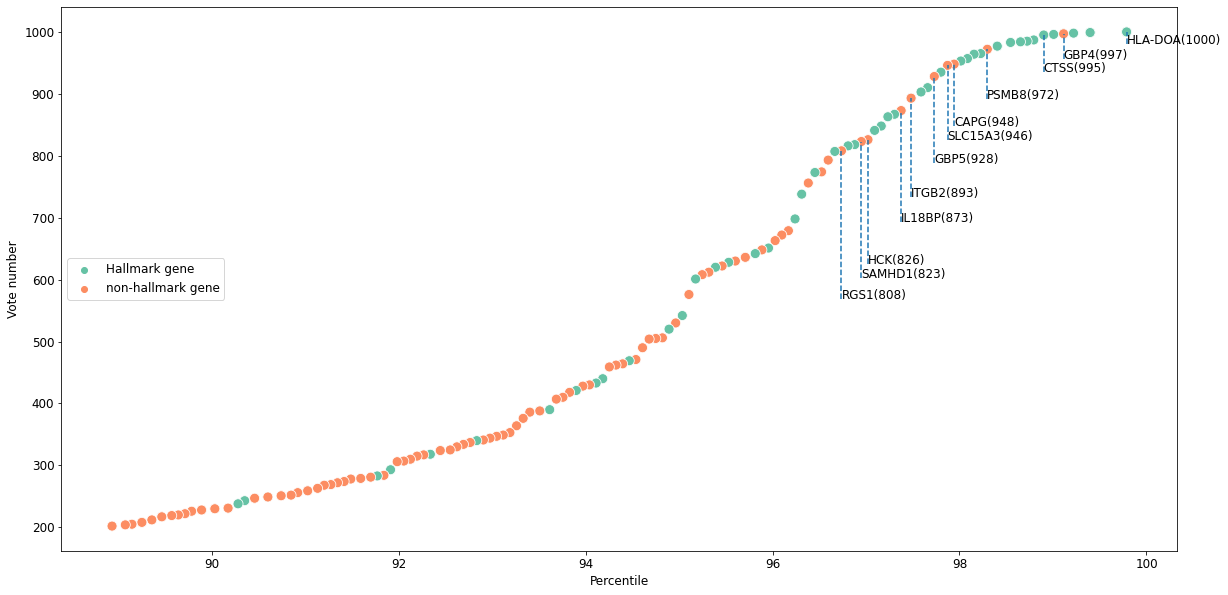

In [52]:
hallmark = pd.read_csv('/home/bruce1996/data/LIHC_anomaly_detection/data/hallmark_gene/hallmark_protein_coding_ens_id.txt',sep='\t')
ensemble_path = "/home/bruce1996/data/LIHC_anomaly_detection/manuscript/material/ensemble_learning_result/with_synthetic/"
output_path = "/home/bruce1996/data/LIHC_anomaly_detection/manuscript/Fig2_gene_vote_distribution/"
hallmark_genes = hallmark['EnsID'].values
condition_list = [('hbv_only',35)]
for condition,np_ratio in condition_list :
    vote_df = pd.read_csv(ensemble_path + '%s_ensemble_model_vote_np_ratio_%d.txt' % (condition,np_ratio),sep='\t',index_col=0)
    vote_df['HGNC symbol'] = [ens2hgsc[x] for x in vote_df.index]
    vote_distribution(vote_df,hallmark_genes,output_path,prefix=condition,format='pdf')